In [16]:
import warnings
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

from co2sizing import models, utils
from IPython.display import clear_output

import plotly.express as px
%load_ext autoreload
%autoreload 2

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2,  'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}
px.defaults.color_discrete_sequence = px.colors.qualitative.T10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
_name = "clustered_data_DE"
_self_sufficiencies = [0, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
_subfolder = "./"

In [18]:
# Insert stuff here

In [19]:
cluster_filename = _subfolder + "data/" + _name + ".pickle"

# Clustered data self-sufficiency ?

In [20]:
def load_clustered_data(filename):
    df = pd.read_pickle(filename)
    df = df.loc[:, ["cons_kw", "coef_1kw", "weight", "Cluster_number", "co2_kg_kwh"]]
    return df

def self_consumption_production(df, cons_col, prod_col):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    return result

In [21]:
df = load_clustered_data(cluster_filename)
df.tail()

cons_kw  coef_1kw     weight  Cluster_number  \
Index                                                                 
2019-12-18 23:00:00  10.623565       0.0  18.156425             345   
2019-12-18 23:15:00  11.802755       0.0  18.156425             345   
2019-12-18 23:30:00   9.644514       0.0  18.156425             345   
2019-12-18 23:45:00  10.305322       0.0  18.156425             345   
2019-12-19 00:00:00   9.224325       0.0  18.156425             345   

                     co2_kg_kwh  
Index                            
2019-12-18 23:00:00    0.292754  
2019-12-18 23:15:00    0.292754  
2019-12-18 23:30:00    0.292754  
2019-12-18 23:45:00    0.292754  
2019-12-19 00:00:00    0.292754

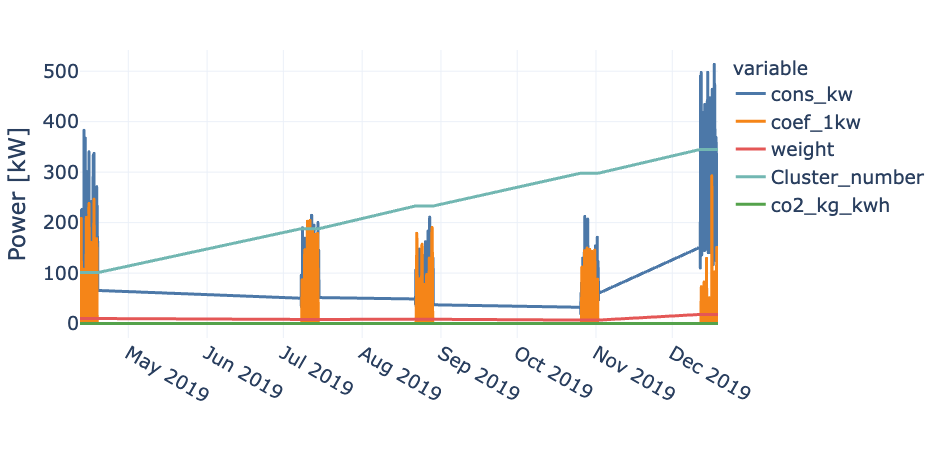

In [22]:
df = load_clustered_data(cluster_filename)
df["cons_kw"] *= df["weight"]
df["coef_1kw"] *= df["weight"]

graph = df.copy()
graph.coef_1kw *= 30
fig = px.line(graph)
fig.update_traces(line_width=3)
fig.update_layout(layout, yaxis_title="Power [kW]", xaxis_title="")
fig.show()

In [23]:
df = load_clustered_data(cluster_filename)
df["cons_kw"] *= df["weight"]
df["coef_1kw"] *= df["weight"]

breakpoint_pv = df["cons_kw"].sum() / df["coef_1kw"].sum()
print(f"PV that produces all energy consumption would be {round(breakpoint_pv, 2)} kWp")

graph = df.copy()
graph.coef_1kw *= breakpoint_pv
res = self_consumption_production(graph, cons_col="cons_kw", prod_col="coef_1kw")
print(f"Self-consumption = {round(res['self_cons'], 2)} % \nSelf-sufficiency = {round(res['self_prod'], 2)} %")
print("")
natural_self = res['self_prod']

PV that produces all energy consumption would be 99.83 kWp
Self-consumption = 34.21 % 
Self-sufficiency = 34.21 %



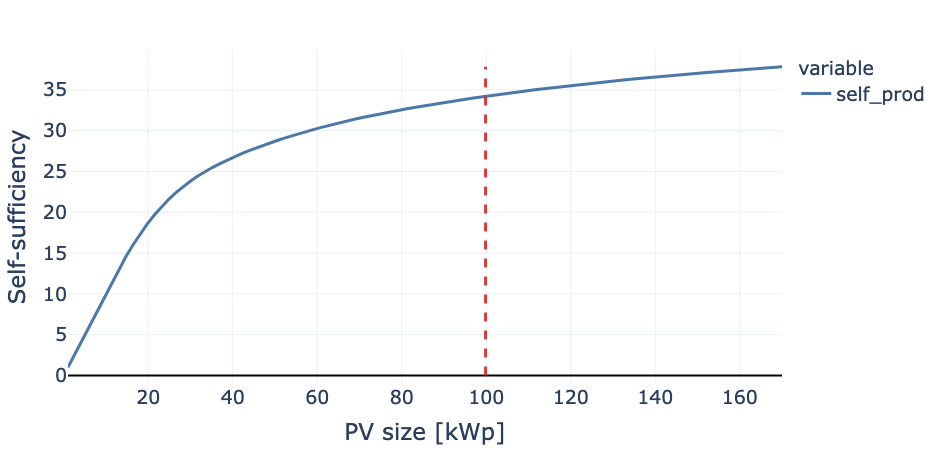

In [24]:
df = load_clustered_data(cluster_filename)
df["cons_kw"] *= df["weight"]
df["coef_1kw"] *= df["weight"]

pv_sizes = list(np.linspace(1, 170, 100))
self_prod = []
for pv_size in pv_sizes:
    graph = df.copy()
    graph.coef_1kw *= pv_size
    res = self_consumption_production(graph, cons_col="cons_kw", prod_col="coef_1kw")
    self_prod.append(res['self_prod'])

graph = pd.DataFrame(index=pv_sizes, data={"self_prod": self_prod})
fig = px.line(graph)
fig.update_traces(line_width=3)
fig.update_layout(layout, yaxis_title="Self-sufficiency", xaxis_title="PV size [kWp]")
fig.add_shape(
  type='line',
  x0=breakpoint_pv, x1=breakpoint_pv, y0=0, y1=graph.self_prod.max(),
  line={'dash': 'dash', 'width': 3,
        'color': 'rgba(214, 39, 40, 0.9)'})
fig.show()

# Create NSS profiles

In [25]:
# Already done 
_name_nss_1 = _name + "_target=60"

# Input matrix

In [26]:
input_col = ["name", "self_sufficiency", "pv_gwp", "battery_gwp",
             "positive_feedback", "cluster_file", "cluster_weight", 
             "natural_self"]
output_col = utils.base.post_process_keys()
matrix = pd.DataFrame(columns=input_col + output_col)

# Sensitivity on countries and min-max envelope
df = load_clustered_data(cluster_filename)
cluster_weight = list(df.weight.unique())

names = [_name, _name_nss_1, _name + "_feedback=028"]
cluster_files = [cluster_filename,
                 _subfolder + "data/NSS/" + _name_nss_1 + ".pickle",
                 cluster_filename]
natural_selfs = [natural_self, 60, natural_self]
positive_feedbacks = [1, 1, 0.972]

battery_gwp = 158
pv_gwp = 1040

for name, cluster_file, natural_self, positive_feedback in zip(names, cluster_files, natural_selfs, positive_feedbacks):
    for self_sufficiency in _self_sufficiencies:
        matrix = matrix.append({
                        "name": name,
                        "self_sufficiency": self_sufficiency / 100,
                        "pv_gwp": pv_gwp,
                        "battery_gwp": battery_gwp,
                        "positive_feedback": positive_feedback,
                        "cluster_file": cluster_file,
                        "cluster_weight": cluster_weight,
                        "natural_self": natural_self}, ignore_index=True)
matrix.head()

name  self_sufficiency pv_gwp battery_gwp positive_feedback  \
0  clustered_data_DE              0.00   1040         158                 1   
1  clustered_data_DE              0.10   1040         158                 1   
2  clustered_data_DE              0.20   1040         158                 1   
3  clustered_data_DE              0.25   1040         158                 1   
4  clustered_data_DE              0.30   1040         158                 1   

                      cluster_file  \
0  ./data/clustered_data_DE.pickle   
1  ./data/clustered_data_DE.pickle   
2  ./data/clustered_data_DE.pickle   
3  ./data/clustered_data_DE.pickle   
4  ./data/clustered_data_DE.pickle   

                                      cluster_weight  natural_self  \
0  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
1  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
2  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
3  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
4  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   

   yearly_cons_mwh  nb_years  co2_kg_mwh_not_discounted  \
0              NaN       NaN                        NaN   
1              NaN       NaN                        NaN   
2              NaN       NaN                        NaN   
3              NaN       NaN                        NaN   
4              NaN       NaN                        NaN   

   co2_kg_not_discounted  co2_kg_mwh  co2_kg  pv_capacity  \
0                    NaN         NaN     NaN          NaN   
1                    NaN         NaN     NaN          NaN   
2                    NaN         NaN     NaN          NaN   
3                    NaN         NaN     NaN          NaN   
4                    NaN         NaN     NaN          NaN   

   pv_capacity_yearlymwh  battery_kwh  battery_kwh_yearlymwh  capex  \
0                    NaN          NaN                    NaN    NaN   
1                    NaN          NaN                    NaN    NaN   
2                    NaN          NaN                    NaN    NaN   
3                    NaN          NaN                    NaN    NaN   
4                    NaN          NaN                    NaN    NaN   

   capex_yearlymwh  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [27]:
matrix.tail()

name  self_sufficiency pv_gwp battery_gwp  \
52  clustered_data_DE_feedback=028              0.80   1040         158   
53  clustered_data_DE_feedback=028              0.85   1040         158   
54  clustered_data_DE_feedback=028              0.90   1040         158   
55  clustered_data_DE_feedback=028              0.95   1040         158   
56  clustered_data_DE_feedback=028              1.00   1040         158   

   positive_feedback                     cluster_file  \
52             0.972  ./data/clustered_data_DE.pickle   
53             0.972  ./data/clustered_data_DE.pickle   
54             0.972  ./data/clustered_data_DE.pickle   
55             0.972  ./data/clustered_data_DE.pickle   
56             0.972  ./data/clustered_data_DE.pickle   

                                       cluster_weight  natural_self  \
52  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
53  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
54  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
55  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   
56  [10.022346368715084, 8.279329608938548, 8.5698...     34.209581   

    yearly_cons_mwh  nb_years  co2_kg_mwh_not_discounted  \
52              NaN       NaN                        NaN   
53              NaN       NaN                        NaN   
54              NaN       NaN                        NaN   
55              NaN       NaN                        NaN   
56              NaN       NaN                        NaN   

    co2_kg_not_discounted  co2_kg_mwh  co2_kg  pv_capacity  \
52                    NaN         NaN     NaN          NaN   
53                    NaN         NaN     NaN          NaN   
54                    NaN         NaN     NaN          NaN   
55                    NaN         NaN     NaN          NaN   
56                    NaN         NaN     NaN          NaN   

    pv_capacity_yearlymwh  battery_kwh  battery_kwh_yearlymwh  capex  \
52                    NaN          NaN                    NaN    NaN   
53                    NaN          NaN                    NaN    NaN   
54                    NaN          NaN                    NaN    NaN   
55                    NaN          NaN                    NaN    NaN   
56                    NaN          NaN                    NaN    NaN   

    capex_yearlymwh  
52              NaN  
53              NaN  
54              NaN  
55              NaN  
56              NaN

# Optimization

In [28]:
output_file = _subfolder + "results/NSSvsEnergy_v2_" + _name + ".csv"
subset = matrix.copy()

_index = 1
for index, row in subset.iterrows():
    if index % 2 == 0:
        clear_output(wait=True)
    print("")
    print("##########")
    print(f"Optimization status {round(_index * 100 /len(subset))} %")
    print(matrix.loc[index, input_col])
    print("")
    _index += 1
    
    data = []
    clusters = pd.read_pickle(row["cluster_file"])
    for _, frame in clusters.groupby("Cluster_number"):
        data.append(frame.copy())
    
    yearly_cons_mwh = (clusters.weight * clusters.cons_kw).sum() / 4 / 1000
    soh = [1.0*0.93**n for n in range(8)]
    pv_ageing = [1 - 0.005 * i for i in range(20)]
    postive_feedback = [1.0*row["positive_feedback"]**n for n in range(0, 20)]
    
    if row["positive_feedback"] != 1:
        yearly_cons_mwh = sum([yearly_cons_mwh * postive_feedback[n] for n in range(0, 20)]) / 20
    
    inputs = {
        'pv_gwp': row["pv_gwp"],  # kgCo2/kW
        'battery_gwp': row["battery_gwp"],  # kgCO2/kWh, lifetime = 8 years (4 years discounted)
        'self_sufficiency': row["self_sufficiency"],
        "period_coefs": row["cluster_weight"],
        'battery_eta': 0.95,
        "soh_coefs": soh,
        "pv_ageing_coefs": pv_ageing,
        "positiv_coefs": postive_feedback
    }
    
    print(f"Yearly consumption = {round(yearly_cons_mwh, 2)} MWh")
    print(f"Unique CO2 data points {clusters.co2_kg_kwh.unique()}")
    print(f"SoH after 8 years = {np.round(soh[-1] * 100, 2)} %")
    print(f"PV after 20 years = {np.round(pv_ageing[-1] * 100, 2)} %")
    print(f"Feedback after 20 years = {np.round(postive_feedback[-1] * 100, 2)} %")
    print("")
    
    model = models.base.optimize(data, **inputs, verbose=False, solver="gurobi")
    result = utils.base.post_process(model, data, inputs["period_coefs"], yearly_cons_mwh)
    
    subset["battery_kwh"] = subset["battery_kwh"].astype(object)
    subset["battery_kwh_yearlymwh"] = subset["battery_kwh_yearlymwh"].astype(object)
    for col in output_col:
        subset.at[index, col] = result[col]
    subset.to_csv(output_file, sep=";")


##########
Optimization status 100 %
name                                    clustered_data_DE_feedback=028
self_sufficiency                                                   1.0
pv_gwp                                                            1040
battery_gwp                                                        158
positive_feedback                                                0.972
cluster_file                           ./data/clustered_data_DE.pickle
cluster_weight       [10.022346368715084, 8.279329608938548, 8.5698...
natural_self                                                 34.209581
Name: 56, dtype: object

Yearly consumption = 76.38 MWh
Unique CO2 data points [0.29275378]
SoH after 8 years = 60.17 %
PV after 20 years = 90.5 %
Feedback after 20 years = 58.3 %

Self-sufficiency   = 100.0 %
CO2 emission       = 576.6 kgCO2eq/MWh
CO2 emission disc. = -1429.97 kgCO2eq/MWh
PV capacity        = 8.42 kWp/yearlyMWh
Battery capacity   = [9.01, 6.51, 4.1] kWh/yearlyMWh
CO2 CAPEX 

# Visualization

In [29]:
# Re run graph
#_name = "clustered_data_DE"
#_subfolder = "./"
#output_file = _subfolder + "results/NSSvsEnergy_" + _name + ".csv"

In [30]:
df = pd.read_csv(output_file, sep=";", index_col=0)
df["battery_kwh"] = df["battery_kwh"].apply(lambda x: eval(x))
df["battery_kwh_yearlymwh"] = df["battery_kwh_yearlymwh"].apply(lambda x: eval(x))
df["cluster_weight"] = df["cluster_weight"].apply(lambda x: eval(x))
df.tail(5).T

52  \
name                                          clustered_data_DE_feedback=028   
self_sufficiency                                                         0.8   
pv_gwp                                                                  1040   
battery_gwp                                                              158   
positive_feedback                                                      0.972   
cluster_file                                 ./data/clustered_data_DE.pickle   
cluster_weight             [10.022346368715084, 8.279329608938548, 8.5698...   
natural_self                                                       34.209581   
yearly_cons_mwh                                                    76.377424   
nb_years                                                                20.0   
co2_kg_mwh_not_discounted                                             218.58   
co2_kg_not_discounted                                              333895.64   
co2_kg_mwh                                                             55.33   
co2_kg                                                              84516.06   
pv_capacity                                                           103.21   
pv_capacity_yearlymwh                                                   1.35   
battery_kwh                                         [253.59, 194.42, 140.34]   
battery_kwh_yearlymwh                                     [3.32, 2.55, 1.84]   
capex                                                              201997.77   
capex_yearlymwh                                                       2645.0   

                                                                          53  \
name                                          clustered_data_DE_feedback=028   
self_sufficiency                                                        0.85   
pv_gwp                                                                  1040   
battery_gwp                                                              158   
positive_feedback                                                      0.972   
cluster_file                                 ./data/clustered_data_DE.pickle   
cluster_weight             [10.022346368715084, 8.279329608938548, 8.5698...   
natural_self                                                       34.209581   
yearly_cons_mwh                                                    76.377424   
nb_years                                                                20.0   
co2_kg_mwh_not_discounted                                             256.55   
co2_kg_not_discounted                                              391888.18   
co2_kg_mwh                                                           -195.59   
co2_kg                                                            -298771.54   
pv_capacity                                                           189.79   
pv_capacity_yearlymwh                                                   2.48   
battery_kwh                                         [252.64, 200.85, 142.81]   
battery_kwh_yearlymwh                                     [3.31, 2.63, 1.87]   
capex                                                               291677.5   
capex_yearlymwh                                                       3819.0   

                                                                          54  \
name                                          clustered_data_DE_feedback=028   
self_sufficiency                                                         0.9   
pv_gwp                                                                  1040   
battery_gwp                                                              158   
positive_feedback                                                      0.972   
cluster_file                                 ./data/clustered_data_DE.pickle   
cluster_weight             [10.022346368715084, 8.279329608938548, 8.5698...   
natural_self                                                       34.20

# Discounted graph

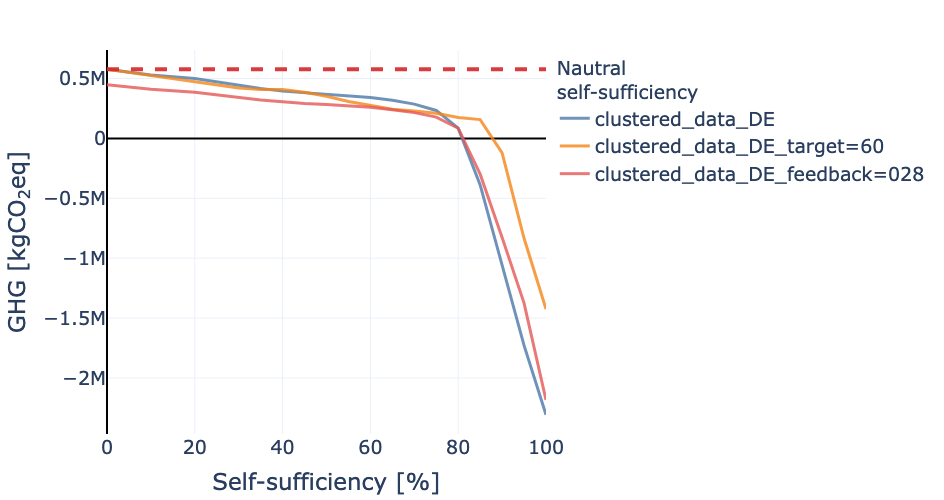

In [31]:
graph = df.copy()
graph["text"] = graph.apply(lambda x: f"{x.pv_capacity_yearlymwh}kWp/MWh — {round(np.mean(x.battery_kwh_yearlymwh), 2)}kWh/MWh", axis=1)
graph = graph.sort_values(["pv_gwp", "self_sufficiency"])
graph["self_sufficiency"] *= 100

fig = px.line(graph, x="self_sufficiency", y="co2_kg", color="name", hover_data=["text"])
fig.update_traces({"line": {"width": 3}, "opacity": 0.8})

fig.add_shape(
  type='line',
  xref="paper",
  x0=0, x1=1,
  y0=graph.iloc[0]["co2_kg"],
  y1=graph.iloc[0]["co2_kg"],
  line={'dash': 'dash', 'width': 4,
        'color': 'rgba(214, 39, 40, 0.9)'})

fig.update_layout(
    layout,
    height=500,
    width=900,
    legend_title="Nautral<br>self-sufficiency",
    showlegend=True,
    xaxis={"title": "Self-sufficiency [%]",
           "showline": False, "linecolor": "black", "linewidth": 2},
    yaxis={"title": "GHG [kgCO<sub>2</sub>eq]",
           "showline": False, "linecolor": "black", "linewidth": 1})
fig.show()

# Not discounted (paper version)

In [38]:
graph = df.copy()
graph["text"] = graph.apply(lambda x: f"{x.pv_capacity}kWp — {round(np.mean(x.battery_kwh), 2)}kWh", axis=1)
graph = graph.sort_values(["pv_gwp", "self_sufficiency"])
graph["self_sufficiency"] *= 100
graph["co2_kg_not_discounted"] /= (1000 * 20 * 20)

fig = px.line(graph, x="self_sufficiency", y="co2_kg_not_discounted", color="name", hover_data=["text"])
fig.update_traces({"line": {"width": 3}, "opacity": 0.8})

fig.add_shape(
  type='line',
  xref="paper",
  x0=0, x1=1,
  y0=graph.iloc[0]["co2_kg_not_discounted"],
  y1=graph.iloc[0]["co2_kg_not_discounted"],
  line={'dash': 'dash', 'width': 4,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.data[0].update(name="Reference NSS=34.2%", showlegend=True)
fig.data[1].update(name="Increased flexibility NSS=60%", showlegend=True)
fig.data[2].update(name="Reduced consumption 2.8% per year (NSS=34.2%)", showlegend=True)

fig.data[0].update(line_width=4)
fig.data[1].update(fill="tonexty", fillcolor="rgba(255, 127, 14, 0.1)")
fig.data[2].update(line_dash="dot", line_width=4)

fig.add_annotation(
  x=60,
  y=1.05,
  ax=0,
  ay=0,
  bgcolor="white",
  text=f"""Ref""",
  font={"color": "rgba(55, 128, 191, 1.0)", 'size': 15})

fig.update_layout(
    layout,
    height=720,
    width=800,
    legend={"x": 0.01, "y": 1},
    legend_title="",
    showlegend=True,
    xaxis={"title": "Self-sufficiency [%]",
           "showline": True, "linecolor": "black", "linewidth": 2},
    yaxis={"title": "GHG [tCO<sub>2</sub>eq/year/house]", "dtick": 0.25,
           "showline": False, "linecolor": "black", "linewidth": 1})
fig.show()

In [39]:
fig.write_image(_subfolder + "results/fig_NSSvsEnergy_v2_" + _name + ".pdf")
fig.write_html(_subfolder + "results/fig_NSSvsEnergy_v2_" + _name + ".html", include_plotlyjs="cdn")

In [40]:
import pickle
with open(_subfolder + "results/fig_NSSvsEnergy_v2_" + _name + ".pickle", "wb") as output_file:
    pickle.dump(fig, output_file)